# Test Segregation Score

This notebooks test the secregation score used to classify degree of mixing between PA and SA using synthetic datasets. Index adapted from [Dogsa & Mandic-Mulec, 2023](https://doi.org/10.1016/j.bioflm.2023.100157).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from pathlib import Path
from scipy.integrate import trapezoid
import statsmodels.api as sm


# Colormap 
n_species = 2
cmap = plt.get_cmap('Spectral',n_species)  # You can choose any colormap, e.g., 'plasma', 'jet', 'coolwarm', etc.
colors = cmap(np.linspace(0, 1, n_species)) 


# main function to calculate segregation scores for point data
def calc_segregation_scores_points(df, window_sizes, focal_type=1, other_type=0):
    '''
    Calculate segregation scores for focal species using point data over specified window sizes.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with point data including species labels
        requires columns 'x', 'y', 'Type'
    window_sizes : list of int
        List of window sizes for calculating segregation scores  
    focal_type : int/ str
        Label of focal species type (default 1)
    other_type : int / str
        Label of non-focal species type (default 0)
    Returns:
    --------
    MSSL : float
        Multiscale spatial segregation level
    mean_segregation : np.ndarray
        Mean segregation scores for each window size
    std_segregation : np.ndarray
        Standard deviation of segregation scores for each window size
    
    '''

    x_cors = df['x'].values
    y_cors = df['y'].values
    types = df['Type'].values

    # Calculate global frequency of focal species
    N_focal_G = np.sum(types == focal_type)
    N_other_G = np.sum(types == other_type)

    segregation_scores = []
    for idx, row in df.iterrows():
        if row['Type'] == focal_type:

            # calculate distances from focal cell to all other cells
            dist = np.sqrt((x_cors - row['x'])**2 + (y_cors - row['y'])**2)
            segregation_cell = np.empty(len(window_sizes))
            
            #calculate segregation scores for each window size
            for idx, window_size in enumerate(window_sizes):

                neighbors = (dist > 0) & (dist <= window_size)
                N_focal_L = np.sum(types[neighbors] == focal_type)
                N_other_L = np.sum(types[neighbors] == other_type)  

                if N_focal_L == 0 and N_other_L == 0:
                    segregation_cell[idx] = np.nan
                else:
                    segregation_cell[idx] = np.abs(N_focal_L/N_focal_G - N_other_L/N_other_G) / (N_focal_L/N_focal_G + N_other_L/N_other_G)

                segregation_scores.append(segregation_cell)

    # Compute mean and std of segregation scores
    segregation_scores = np.array(segregation_scores)
    mean_segregation = np.mean(segregation_scores, axis=0)
    std_segregation = np.std(segregation_scores, axis=0)


    # Calculate area under curve
    non_nan_indices = ~np.isnan(mean_segregation)
    mean_segregation_nn = mean_segregation[non_nan_indices]
    window_sizes_nn = window_sizes[non_nan_indices]
    area = trapezoid(mean_segregation_nn, window_sizes_nn)
    # Calculate multiscale spatial segregation level
    MMSL = area / (window_sizes_nn[-1] - window_sizes_nn[0])
    return (MMSL, mean_segregation, std_segregation)

# Load data set

df_data should contain columns:
- x: x-location of cells (in um or pixel)
- y: y-location of cells (in um or pixel)
- Type: integer {0,1} indicating PA (0) or SA (1)
- replicate: unique chamber id (string or integer)
- survived: {0,1} indicates if cell regrows or not (alternatively this can be regrowth frequency of replicate, or boolean indicating if there is any regrwoth or not)

In [2]:
data_dir = Path.cwd().parent / 'datafiles'
df_data = pd.read_csv(data_dir / "mixed_chamber_tolerance.csv")

pixel_to_um = 0.065  # µm per pixel

# Convert coordinates from pixels to micrometers
df_data['x'] = df_data['x'] * pixel_to_um
df_data['y'] = df_data['y'] * pixel_to_um

In [3]:
# Window sizes in micrometers (converted from pixels)
window_sizes = np.arange(2, 26, 1)  # 1 to 25 µm

output = []
for rep in df_data['replicate'].unique():
    df_rep = df_data[df_data['replicate'] == rep]
    
    # Get survival fraction in this replicate
    df_rep_sa = df_rep[df_rep['Type'] == 1]

    n_sa = df_rep_sa.shape[0]
    n_sa_survived = df_rep_sa['survived'].sum()
    surv_fraction = n_sa_survived / n_sa
    regrowth_in_chamber = n_sa_survived > 0

    # Calculate LOD
    LOD = 1 / n_sa


    #calculate segregation scores
    MSSL, mean_segregation, std_segregation = calc_segregation_scores_points(
        df_rep, window_sizes, focal_type=1, other_type=0
    )
    
    stats = {
        'replicate': rep,
        'survival_fraction': surv_fraction,
        'regrowth_in_chamber': regrowth_in_chamber,
        'MSSL': MSSL,
        'LOD': LOD
    }

    output.append(stats)

df_aggregated = pd.DataFrame(output)

Spearman correlation:
  ρ = 0.554
  R² = 0.307
  p-value = 0.0005601


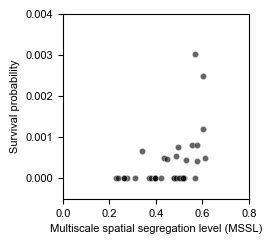

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Plot style
# -----------------------------
font_size = 8
plt.rcParams.update({
    'font.size': font_size,
    'font.family': 'Arial',
    'axes.labelsize': font_size,
    'axes.titlesize': font_size,
    'xtick.labelsize': font_size,
    'ytick.labelsize': font_size,
    'legend.fontsize': font_size,
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})



# -----------------------------
# Plot scatter 
# -----------------------------

#
fig, ax = plt.subplots(figsize=(6/2.5, 6/2.5))

# Scatter points
#sns.scatterplot(data=df_aggregated,x="MSSL",y="survival_fraction",ax=ax,hue="regrowth_in_chamber", palette={True: 'tab:blue', False: 'grey'}, legend=0, style="regrowth_in_chamber", markers={True: 'o', False: 'd'})
sns.scatterplot(data=df_aggregated,x="MSSL",y="survival_fraction",ax=ax,color="black",legend=0,  markers='o', s=20, alpha=0.6)

# -----------------------------
# Labels & limits
# -----------------------------
ax.set_xlabel("Multiscale spatial segregation level (MSSL)")
ax.set_ylabel("Survival probability")
ax.set_xlim(0, 0.8)
ax.set_ylim(-0.0005, 0.004)  # Adjust as needed
ax.set_yticks(np.linspace(0, 0.004, 5))
ylabels= [f"{y:.3f}" for y in ax.get_yticks()]
# ylabels[0] = "below LOD"
ax.set_yticklabels(ylabels)

plt.savefig("./figures/mixed_chambers_observed_survival.pdf", bbox_inches='tight')

# -----------------------------
# Calculate Spearman correlation
# -----------------------------
from scipy.stats import spearmanr
rho, pval = spearmanr(df_aggregated['MSSL'], df_aggregated['survival_fraction'])
r2 = rho**2

print(f"Spearman correlation:")
print(f"  ρ = {rho:.3f}")
print(f"  R² = {r2:.3f}")
print(f"  p-value = {pval:.4g}")
